In [16]:
import pandas as pd
df = pd.read_csv("../data/statcast_pitch_swing_data_20240402_20241030_with_arm_angle2.csv")

# Remove columns that are completely empty
empty_columns = df.columns[df.isnull().all()]
print(f"Columns that are completely empty and will be dropped: {empty_columns.tolist()}")
df = df.drop(columns=empty_columns)

Columns that are completely empty and will be dropped: ['spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id']


In [17]:
df_info = df.dtypes
print(df_info)

pitch_type                      object
game_date                       object
release_speed                  float64
release_pos_x                  float64
release_pos_z                  float64
                                ...   
batter_days_until_next_game    float64
api_break_z_with_gravity       float64
api_break_x_arm                float64
api_break_x_batter_in          float64
arm_angle                      float64
Length: 105, dtype: object


In [18]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop(['game_date', 'player_name'], errors='ignore')

for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column Name: {col}")
    print(f"Number of Categories: {len(unique_values)}")
    print(f"Categories: {unique_values}\n")

Column Name: pitch_type
Number of Categories: 18
Categories: ['FF' 'CH' 'SI' 'KC' 'SL' 'ST' 'FC' 'CU' 'SV' 'FS' 'PO' 'FO' 'FA' 'KN'
 'EP' 'CS' nan 'SC']

Column Name: events
Number of Categories: 22
Categories: ['single' nan 'field_out' 'strikeout' 'walk' 'home_run' 'force_out'
 'field_error' 'double' 'grounded_into_double_play' 'hit_by_pitch'
 'catcher_interf' 'triple' 'sac_fly' 'double_play' 'sac_bunt'
 'fielders_choice' 'truncated_pa' 'fielders_choice_out'
 'strikeout_double_play' 'sac_fly_double_play' 'triple_play']

Column Name: description
Number of Categories: 13
Categories: ['hit_into_play' 'foul' 'called_strike' 'foul_tip' 'ball'
 'swinging_strike' 'blocked_ball' 'swinging_strike_blocked' 'hit_by_pitch'
 'foul_bunt' 'pitchout' 'missed_bunt' 'bunt_foul_tip']

Column Name: des
Number of Categories: 121513
Categories: ['Brayan Rocchio singles on a pop up to left fielder Dominic Canzone.   Bo Naylor to 2nd.'
 'Anthony Rizzo grounds out softly, pitcher Zac Gallen to first baseman C

In [19]:
# Keep only regular season data
df = df[df['game_type'] == 'R']

# Convert game_date to datetime type
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

# Drop game_year column (all data is from 2024)
df = df.drop(columns=['game_year'])

# Create new binary variables for base runners
df['runner_on_1b'] = df['on_1b'].notna().astype(int)  # 1 means a runner is present, 0 means no runner
df['runner_on_2b'] = df['on_2b'].notna().astype(int)
df['runner_on_3b'] = df['on_3b'].notna().astype(int)

# Drop player ID columns
df = df.drop(columns=['player_name', 'batter', 'pitcher', 'on_1b', 'on_2b', 'on_3b', 
                       'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 
                       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9'])

# Create score difference column
df['score_diff'] = df['bat_score'] - df['fld_score']

In [20]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def apply_pca_for_release_pos(df):
    """
    Calculate PCA principal component: a single variable representing the overall information
    of the pitch release position based on three coordinates.
    """
    pca = PCA(n_components=1)
    pos_data = df[['release_pos_x', 'release_pos_y', 'release_pos_z']].dropna()

    df['release_pca'] = np.nan  # Initialize a new column with NaN values

    pca_result = pca.fit_transform(pos_data)
    df.loc[pos_data.index, 'release_pca'] = pca_result.flatten()  # Assign the PCA results

    return df

def calculate_pitch_movement(df):
    """
    Calculate the total movement distance of the pitch.
    """
    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)  # Calculate hypotenuse of pfx_x and pfx_z
    return df

# Apply the calculations
df = calculate_pitch_movement(df)
df = apply_pca_for_release_pos(df)

In [21]:
print("Pitcher Feature Statistics:")
print(df[['release_speed', 'release_spin_rate', 'spin_axis', 'release_pca', 'total_movement', 'plate_x', 'plate_z']].describe())

print("\nBatter Feature Statistics:")
print(df[['launch_speed', 'launch_angle', 'swing_length', 'bat_speed']].describe())

Pitcher Feature Statistics:
       release_speed  release_spin_rate      spin_axis   release_pca  \
count  688484.000000      685509.000000  685511.000000  6.884850e+05   
mean       89.153659        2256.259474     175.757766  4.625353e-16   
std         5.984613         362.251001      72.808618  1.872183e+00   
min        31.900000           9.000000       0.000000 -3.943326e+00   
25%        84.900000        2104.000000     128.000000 -1.314274e+00   
50%        90.000000        2288.000000     200.000000 -6.797108e-01   
75%        94.000000        2465.000000     224.000000  1.679706e+00   
max       105.500000        3578.000000     360.000000  5.425570e+00   

       total_movement        plate_x        plate_z  
count   688485.000000  688485.000000  688485.000000  
mean         1.208848       0.054717       2.304578  
std          0.439982       0.838610       0.964725  
min          0.000000      -5.380000      -7.650000  
25%          0.894036      -0.510000       1.670000  

In [22]:
# Check for missing values in all variables
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing values for each variable:")
    print(missing_values[missing_values > 0].sort_values(ascending=False))    

# Fill missing values
def fill_missing_values(df):
    filled_df = df.copy()

    # Columns to exclude (ID-related columns)
    exclude_columns = ['player_name', 'batter', 'pitcher', 'on_1b', 'on_2b', 'on_3b', 'game_pk',
                       'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9']

    # Fill numerical variables with the median
    numerical_columns = [col for col in filled_df.select_dtypes(include=['float64', 'int64']).columns if col not in exclude_columns]
    for col in numerical_columns:
        median_value = filled_df[col].median()
        filled_df[col].fillna(median_value, inplace=True)
        print(f"Missing values in {col} have been filled with median {median_value}")

    # Fill categorical variables with the default value "Nothing happened or Data missed"
    categorical_columns = [col for col in filled_df.select_dtypes(include=['object']).columns if col not in exclude_columns]
    for col in categorical_columns:
        filled_df[col].fillna("Nothing happened or Data missed", inplace=True)
        print(f"Missing values in {col} have been filled with 'Nothing happened or Data missed'")

    return filled_df


print("Checking for missing values...")
check_missing_values(df)

print("Filling missing values...")
filled_df = fill_missing_values(df)


Checking for missing values...
Missing values for each variable:
launch_speed_angle                 568472
estimated_ba_using_speedangle      568472
estimated_slg_using_speedangle     568472
hc_x                               568148
hc_y                               568148
bb_type                            568101
hit_location                       533503
estimated_woba_using_speedangle    513106
woba_denom                         512261
babip_value                        511890
events                             511890
woba_value                         511890
iso_value                          511890
launch_speed                       457873
launch_angle                       457574
hit_distance_sc                    456394
hyper_speed                        456351
bat_speed                          372120
swing_length                       372120
pitcher_days_until_next_game        27728
pitcher_days_since_prev_game        18734
batter_days_until_next_game          6194
release_spi

Missing values in home_team have been filled with 'Nothing happened or Data missed'
Missing values in away_team have been filled with 'Nothing happened or Data missed'
Missing values in type have been filled with 'Nothing happened or Data missed'
Missing values in bb_type have been filled with 'Nothing happened or Data missed'
Missing values in inning_topbot have been filled with 'Nothing happened or Data missed'
Missing values in pitch_name have been filled with 'Nothing happened or Data missed'
Missing values in if_fielding_alignment have been filled with 'Nothing happened or Data missed'
Missing values in of_fielding_alignment have been filled with 'Nothing happened or Data missed'


In [23]:
def transform_categorical_to_numeric(df):
    transformed_df = df.copy()
    transformed_df['p_throws'] = transformed_df['p_throws'].replace({'L': 0, 'R': 1})
    transformed_df['stand'] = transformed_df['stand'].replace({'L': 0, 'R': 1})

    transformed_df['type'] = transformed_df['type'].replace({'B': 0, 'S': 1, 'X': 2})

    transformed_df['inning_topbot'] = transformed_df['inning_topbot'].replace({'Top': 0, 'Bot': 1})

    fielding_mapping = {'Standard': 0, 'Infield shade': 1, 'Strategic': 2, '4th outfielder': 3, 'Nothing happened or Data missed': -1}
    transformed_df['if_fielding_alignment'] = transformed_df['if_fielding_alignment'].replace(fielding_mapping)
    transformed_df['of_fielding_alignment'] = transformed_df['of_fielding_alignment'].replace(fielding_mapping)

    pitch_type_mapping = {pitch: i for i, pitch in enumerate(df['pitch_type'].dropna().unique())}
    transformed_df['pitch_type'] = transformed_df['pitch_type'].replace(pitch_type_mapping)

    events_mapping = {event: i for i, event in enumerate(df['events'].dropna().unique())}
    transformed_df['events'] = transformed_df['events'].replace(events_mapping)

    bb_type_mapping = {bb: i for i, bb in enumerate(df['bb_type'].unique())}
    transformed_df['bb_type'] = transformed_df['bb_type'].replace(bb_type_mapping)
    
    return transformed_df  

def calculate_frequency_and_percent(df):
    categorical_columns = ['p_throws', 'stand', 'type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'pitch_type', 'events', 'bb_type', 'runner_on_1b', 'runner_on_2b', 'runner_on_3b']
    for col in categorical_columns:
        print(f"column: {col}")
        frequency = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(normalize=True, dropna=False) * 100
        freq_df = pd.DataFrame({'Frequency': frequency, 'Percent (%)': percent})
        print(freq_df)

transformed_df = transform_categorical_to_numeric(filled_df)
calculate_frequency_and_percent(transformed_df)

column: p_throws
   Frequency  Percent (%)
1     504075    73.184701
0     184696    26.815299
column: stand
   Frequency  Percent (%)
1     392815    57.031292
0     295956    42.968708
column: type
   Frequency  Percent (%)
1     322762    46.860568
0     245339    35.619821
2     120670    17.519611
column: inning_topbot
   Frequency  Percent (%)
0     351384    51.016085
1     337387    48.983915
column: if_fielding_alignment
    Frequency  Percent (%)
 0     462435    67.139151
 1     163291    23.707589
 2      60277     8.751385
-1       2768     0.401875
column: of_fielding_alignment
    Frequency  Percent (%)
 0     661597    96.054712
 2      24405     3.543268
-1       2768     0.401875
 3          1     0.000145
column: pitch_type
    Frequency  Percent (%)
0      219020    31.798667
2      109707    15.927935
4      109173    15.850406
1       70189    10.190470
6       56166     8.154525
7       45396     6.590870
5       41739     6.059924
9       20722     3.008547
3   

/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


release_speed does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


release_spin_rate does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


spin_axis does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


release_pca does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


total_movement does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


plate_x does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


plate_z does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


launch_speed does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


launch_angle does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


swing_length does not follow a normal distribution


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


bat_speed does not follow a normal distribution


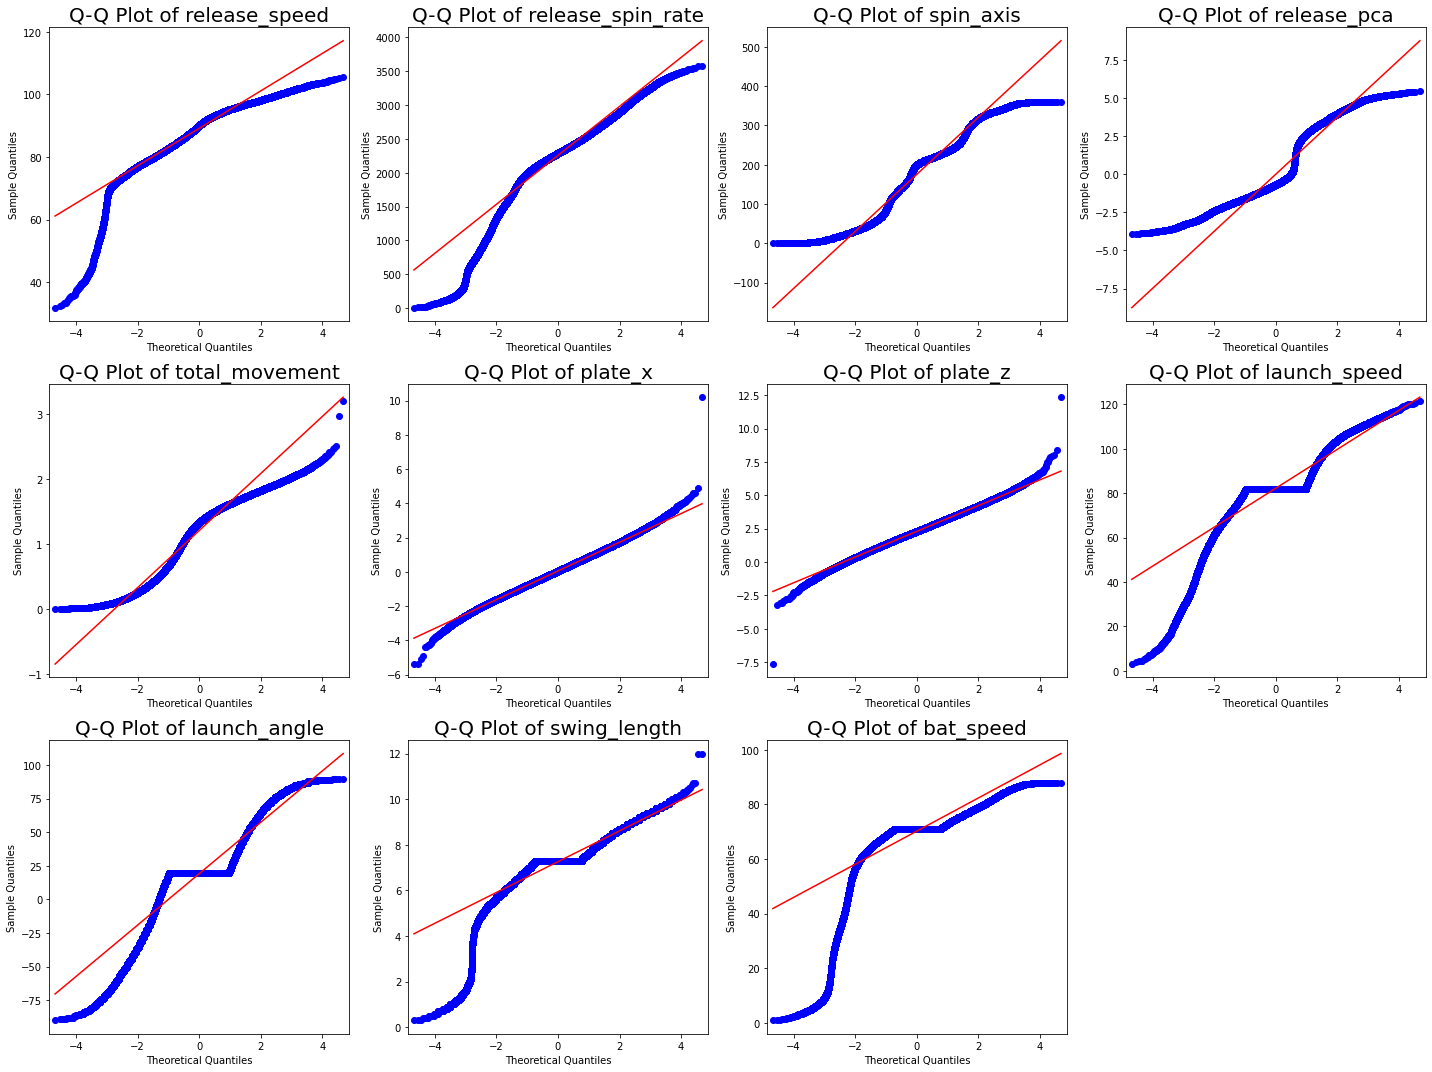

In [24]:
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.pyplot as plt

def check_normality(df, columns, rows=2, cols=4):
    """
    Plot Q-Q plots for multiple continuous variables and perform Shapiro-Wilk tests.
    """
    num_plots = len(columns)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  

    for i, column in enumerate(columns):
        if i >= rows * cols:
            break  # Prevent exceeding the number of subplots
        data = df[column].dropna()
        if len(data) > 0:
            sm.qqplot(data, line='s', ax=axes[i])
            axes[i].set_title(f'Q-Q Plot of {column}', fontsize=20)

            # Shapiro-Wilk test
            stat, p_value = shapiro(data)
            if p_value > 0.05:
                print(f'{column} is approximately normally distributed')
            else:
                print(f'{column} does not follow a normal distribution')
        else:
            axes[i].set_visible(False)  # Hide subplot if there is insufficient data

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()  # Automatically adjust layout
    plt.show()


continuous_variables = ['release_speed', 'release_spin_rate', 'spin_axis', 'release_pca','total_movement','plate_x','plate_z',
                        'launch_speed', 'launch_angle', 'swing_length', 'bat_speed']
check_normality(transformed_df, continuous_variables, rows=3, cols=4)  


Variables：'release_speed', 'release_spin_rate', 'spin_axis', 'release_pca', 'total_movement', 'plate_x', 'plate_z',
'launch_speed', 'launch_angle', 'swing_length', 'bb_type', 'runner_on_1b', 'runner_on_2b', 'runner_on_3b',
'p_throws', 'stand', 'type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'pitch_type'

In [25]:
from scipy.stats import levene

def check_variance_homogeneity(df, group_col, value_col):
    """
    Check variance homogeneity across different groups.
    """
    groups = [group[value_col].dropna() for name, group in df.groupby(group_col)]
    
    # Perform Levene's test
    stat, p_value = levene(*groups)
    print(f"Levene's test p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"The variance of {value_col} is homogeneous across different {group_col} groups (homoscedasticity assumption holds).")
    else:
        print(f"The variance of {value_col} is not homogeneous across different {group_col} groups (homoscedasticity assumption does not hold).")

def batch_variance_checks(df):
    checks = [
        ('release_speed', 'bat_speed'),
        ('release_spin_rate', 'bat_speed'),
        ('spin_axis', 'bat_speed'),
        ('release_pca', 'bat_speed'),
        ('total_movement', 'bat_speed'),
        ('plate_x', 'bat_speed'),
        ('plate_z', 'bat_speed'),
        ('launch_speed', 'bat_speed'),
        ('launch_angle', 'bat_speed'),
        ('swing_length', 'bat_speed'),
        ('bb_type', 'bat_speed'),
        ('runner_on_1b', 'bat_speed'),
        ('runner_on_2b', 'bat_speed'),
        ('runner_on_3b', 'bat_speed'),
        ('p_throws', 'bat_speed'),
        ('stand', 'bat_speed'),
        ('type', 'bat_speed'),
        ('inning_topbot', 'bat_speed'),
        ('if_fielding_alignment', 'bat_speed'),
        ('of_fielding_alignment', 'bat_speed'),
        ('pitch_type', 'bat_speed')
    ]
    
    for group_col, value_col in checks:
        print(f"Checking variance homogeneity between {group_col} and {value_col}:")
        check_variance_homogeneity(df, group_col, value_col)
        print("=" * 50)


batch_variance_checks(transformed_df)

Checking variance homogeneity between release_speed and bat_speed:
Levene's test p-value: 0.0000
The variance of bat_speed is not homogeneous across different release_speed groups (homoscedasticity assumption does not hold).
Checking variance homogeneity between release_spin_rate and bat_speed:
Levene's test p-value: 0.0001
The variance of bat_speed is not homogeneous across different release_spin_rate groups (homoscedasticity assumption does not hold).
Checking variance homogeneity between spin_axis and bat_speed:
Levene's test p-value: 0.0000
The variance of bat_speed is not homogeneous across different spin_axis groups (homoscedasticity assumption does not hold).
Checking variance homogeneity between release_pca and bat_speed:
Levene's test p-value: 1.0000
The variance of bat_speed is homogeneous across different release_pca groups (homoscedasticity assumption holds).
Checking variance homogeneity between total_movement and bat_speed:
Levene's test p-value: 0.1556
The variance of ba

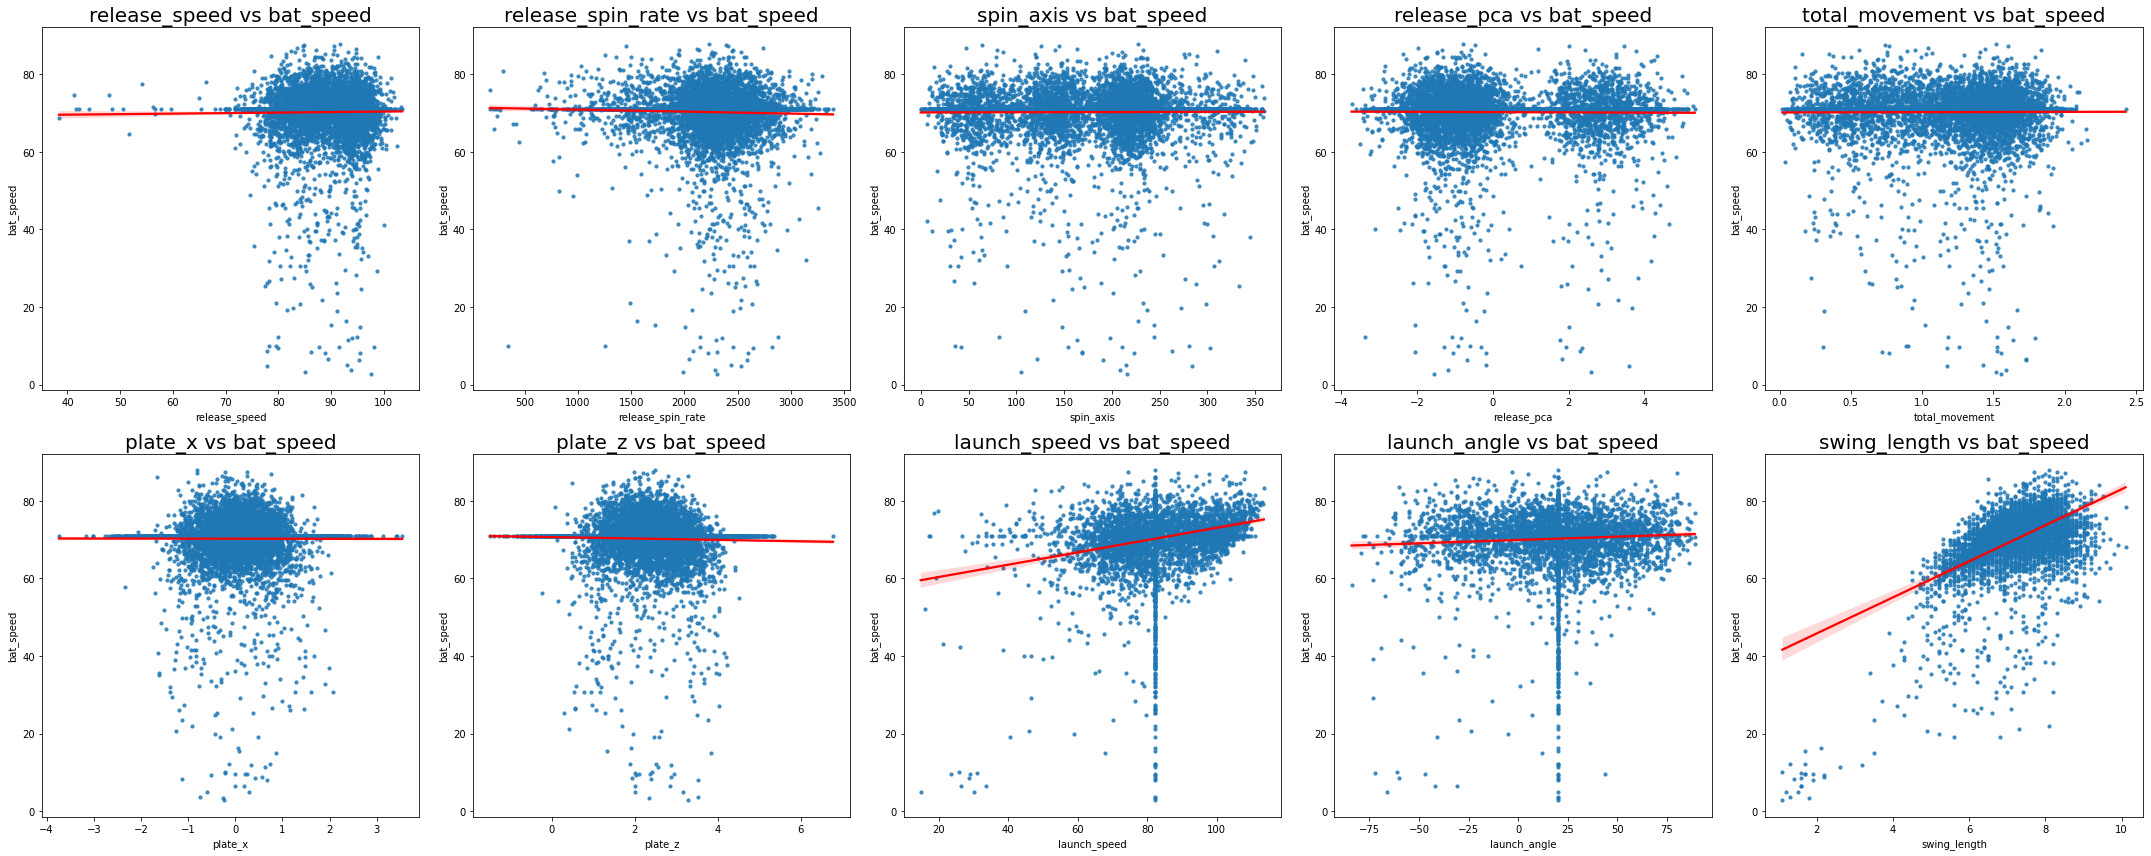

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_with_fit_sampled(df, x_vars, y_var, rows=3, cols=4, sample_size=10000):
    """
    Plot scatter plots for multiple independent variables against the dependent variable, with a fitted line.
    A sample of 10,000 rows is taken due to large dataset size.
    
    """
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)  # Random Select
    num_plots = len(x_vars)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    axes = axes.flatten()  

    for i, x_var in enumerate(x_vars):
        if i >= rows * cols:
            break
        sns.regplot(x=x_var, y=y_var, data=df, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[i].set_title(f'{x_var} vs {y_var}', fontsize=20)
        axes[i].tick_params(axis='both', labelsize=10)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


x_variables = ['release_speed', 'release_spin_rate', 'spin_axis', 'release_pca', 'total_movement', 
               'plate_x', 'plate_z', 'launch_speed', 'launch_angle', 'swing_length']
y_variable = 'bat_speed'

plot_scatter_with_fit_sampled(transformed_df, x_variables, y_variable, rows=2, cols=5, sample_size=10000)

In [27]:
# Calculate the Pearson correlation coefficient between independent and dependent variables
correlation_matrix = transformed_df[x_variables + [y_variable]].corr()
bat_speed_corr = correlation_matrix[y_variable].sort_values(ascending=False)

print("Pearson correlation coefficients with bat_speed:")
print(bat_speed_corr)

Pearson correlation coefficients with bat_speed:
bat_speed            1.000000
swing_length         0.530164
launch_speed         0.226661
launch_angle         0.033495
spin_axis            0.014014
total_movement       0.010711
release_speed        0.008994
release_pca         -0.000710
plate_x             -0.006304
plate_z             -0.021104
release_spin_rate   -0.024370
Name: bat_speed, dtype: float64


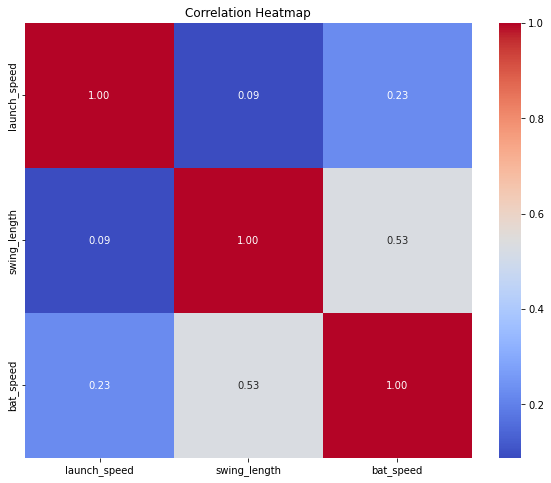

In [28]:
# calculate the correlation matrix and plot a heatmap
plt.figure(figsize=(10, 8))
corr_matrix = transformed_df[['launch_speed', 'swing_length', 'bat_speed']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [29]:
import statsmodels.api as sm

def robust_linear_regression(df):
    """
    Regression Model (OLS with Robust Standard Errors) since most variables do not satisfy the homoscedasticity assumption.
    """
    numerical_vars = ['launch_speed', 'swing_length']
    categorical_vars = ['bb_type', 'runner_on_1b', 'runner_on_2b', 'runner_on_3b', 'p_throws', 
                         'stand', 'type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'pitch_type']

    # Perform one-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df[categorical_vars], drop_first=True)

    X = pd.concat([df[numerical_vars], df_encoded], axis=1)
    X = sm.add_constant(X)  # Add intercept term
    y = df['bat_speed']

    # Construct the OLS model with robust standard errors
    model = sm.OLS(y, X).fit(cov_type='HC3')  
    print(model.summary())

# Run the robust linear regression
robust_linear_regression(transformed_df)


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              bat_speed   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     3236.
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:45:50   Log-Likelihood:            -2.0829e+06
No. Observations:              688771   AIC:                         4.166e+06
Df Residuals:                  688757   BIC:                         4.166e+06
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    26.58

In [30]:
def without_unsignificant_robust_linear_regression(df):
    """
    Remove variables with p-value > 0.05 and return the model object.
    """
    numerical_vars = ['launch_speed', 'swing_length']
    categorical_vars = ['bb_type', 'runner_on_2b', 'stand', 'type', 'if_fielding_alignment', 'pitch_type']

    # Perform one-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df[categorical_vars], drop_first=True)

    X = pd.concat([df[numerical_vars], df_encoded], axis=1)
    X = sm.add_constant(X)  # Add intercept term
    y = df['bat_speed']

    # Construct the OLS model with robust standard errors
    model = sm.OLS(y, X).fit(cov_type='HC3') 
    print(model.summary())
    
    return model  

# Call the function and return the model object
robust_model = without_unsignificant_robust_linear_regression(transformed_df)


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              bat_speed   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     5209.
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:45:51   Log-Likelihood:            -2.0829e+06
No. Observations:              688771   AIC:                         4.166e+06
Df Residuals:                  688762   BIC:                         4.166e+06
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    26.61

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    X = sm.add_constant(df[features])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i + 1) for i in range(len(features))]
    print(vif_data)


features = ['launch_speed', 'swing_length', 
            'bb_type', 'runner_on_2b','stand', 'type', 'if_fielding_alignment', 'pitch_type']
calculate_vif(transformed_df, features)


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                Variable       VIF
0           launch_speed  1.207407
1           swing_length  1.057038
2                bb_type  1.878471
3           runner_on_2b  1.007527
4                  stand  1.081476
5                   type  1.642755
6  if_fielding_alignment  1.083809
7             pitch_type  1.040622


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 576x432 with 0 Axes>

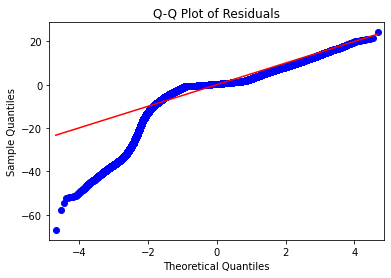

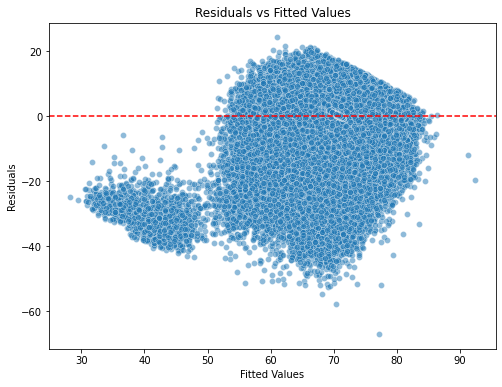

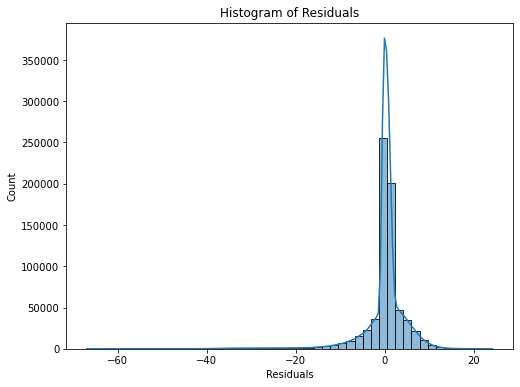

In [32]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(model, df):
    residuals = model.resid
    fitted_values = model.fittedvalues
    
    # 1. Q-Q plot to check the normality of residuals
    plt.figure(figsize=(8, 6))
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # 2. Residual scatter plot to check homoscedasticity
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=fitted_values, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # 3. Histogram to check residual distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.show()

plot_residuals(robust_model, transformed_df)

In [33]:
import numpy as np
from scipy.stats import boxcox
import statsmodels.api as sm
import pandas as pd

def boxcox_linear_regression(df):
    """
    Perform Box-Cox transformation and Weighted Least Squares (WLS) model
    """
    numerical_vars = ['launch_speed', 'swing_length']
    categorical_vars = ['bb_type', 'runner_on_2b', 'stand', 'type', 'if_fielding_alignment', 'pitch_type']

    # Perform Box-Cox transformation for numerical variables
    boxcox_transformed = {}
    lambda_dict = {}

    for col in numerical_vars:
        if (df[col] <= 0).any():
            df[col] += abs(df[col].min()) + 1  # Ensure all values are positive for Box-Cox

        transformed_data, lambda_val = boxcox(df[col])
        boxcox_transformed[col + "_boxcox"] = transformed_data
        lambda_dict[col] = lambda_val

    # Combine Box-Cox transformed data
    boxcox_df = pd.DataFrame(boxcox_transformed)

    df_encoded = pd.get_dummies(df[categorical_vars], drop_first=True)

    # Add interaction terms
    # boxcox_df['swing_launch_interaction'] = boxcox_df['swing_length_boxcox'] * boxcox_df['launch_speed_boxcox']
    # Multicollinearity was too high, so this line is commented out

    X = pd.concat([boxcox_df, df_encoded], axis=1)
    X = sm.add_constant(X)
    y = df['bat_speed']

    # Calculate weights
    model_ols = sm.OLS(y, X).fit()
    weights = 1 / (model_ols.resid ** 2)

    # Weighted Least Squares (WLS) model
    model_wls = sm.WLS(y, X, weights=weights).fit()

    # Output model summary
    print(f"Box-Cox transformation λ values: {lambda_dict}")
    print(model_wls.summary())
    
    boxcox_features = ['launch_speed_boxcox', 'swing_length_boxcox'] + list(df_encoded.columns)

    calculate_vif(pd.concat([boxcox_df, df_encoded], axis=1), boxcox_features)

    return model_wls

# Call the function and return the model object
wls_model = boxcox_linear_regression(transformed_df)


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Box-Cox transformation λ values: {'launch_speed': 1.830773660106187, 'swing_length': 2.6172829168364373}
                            WLS Regression Results                            
Dep. Variable:              bat_speed   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.373e+09
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:46:09   Log-Likelihood:            -1.0148e+06
No. Observations:              688771   AIC:                         2.030e+06
Df Residuals:                  688762   BIC:                         2.030e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------

/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                Variable       VIF
0    launch_speed_boxcox  1.258945
1    swing_length_boxcox  1.056820
2                bb_type  1.927667
3           runner_on_2b  1.007331
4                  stand  1.082248
5                   type  1.634419
6  if_fielding_alignment  1.083864
7             pitch_type  1.047023


/Users/jiehou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 576x432 with 0 Axes>

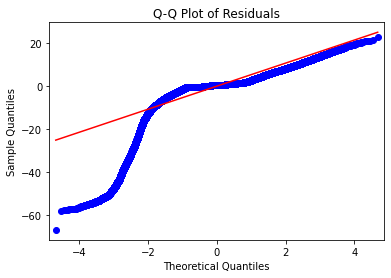

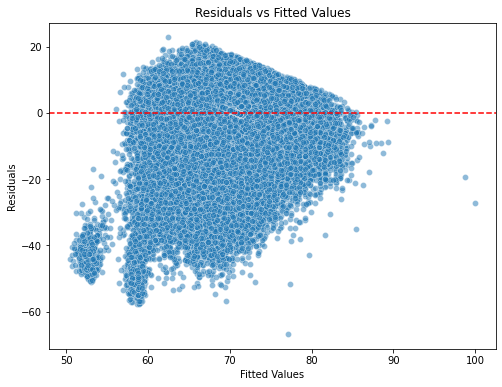

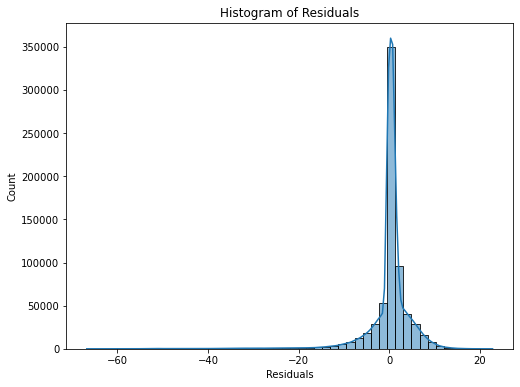

In [34]:
plot_residuals(wls_model, transformed_df)

# Visualization

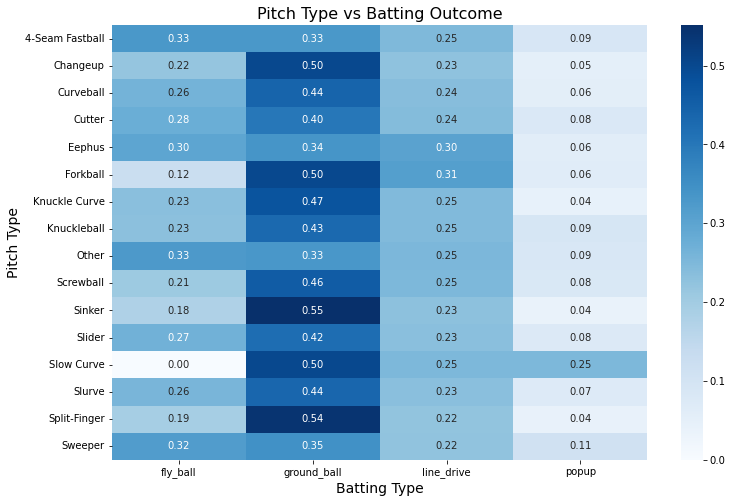

In [35]:
def pitch_vs_bat_heatmap(df):
    pivot_table = pd.crosstab(df['pitch_name'], df['bb_type'], normalize='index')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".2f")
    plt.title('Pitch Type vs Batting Outcome', fontsize=16)
    plt.xlabel('Batting Type', fontsize=14)
    plt.ylabel('Pitch Type', fontsize=14)
    plt.show()

pitch_vs_bat_heatmap(df)

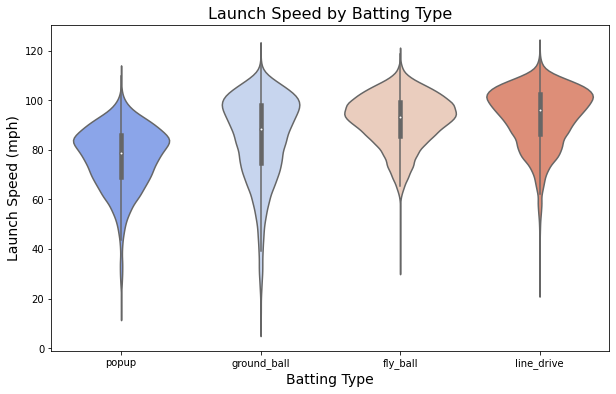

In [36]:
def plot_launch_speed_vs_batting_type(df):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='bb_type', y='launch_speed', data=df, palette='coolwarm')
    plt.title('Launch Speed by Batting Type', fontsize=16)
    plt.xlabel('Batting Type', fontsize=14)
    plt.ylabel('Launch Speed (mph)', fontsize=14)
    plt.show()

plot_launch_speed_vs_batting_type(df)

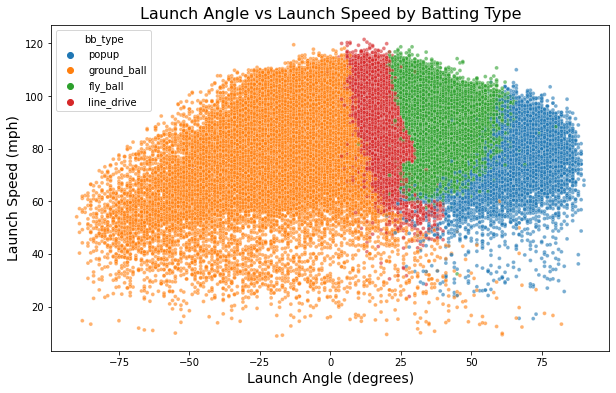

In [37]:
def scatter_launch_angle_speed(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='launch_angle', y='launch_speed', hue='bb_type', data=df,alpha=0.6, s=15)
    plt.title('Launch Angle vs Launch Speed by Batting Type', fontsize=16)
    plt.xlabel('Launch Angle (degrees)', fontsize=14)
    plt.ylabel('Launch Speed (mph)', fontsize=14)
    plt.show()

scatter_launch_angle_speed(df)

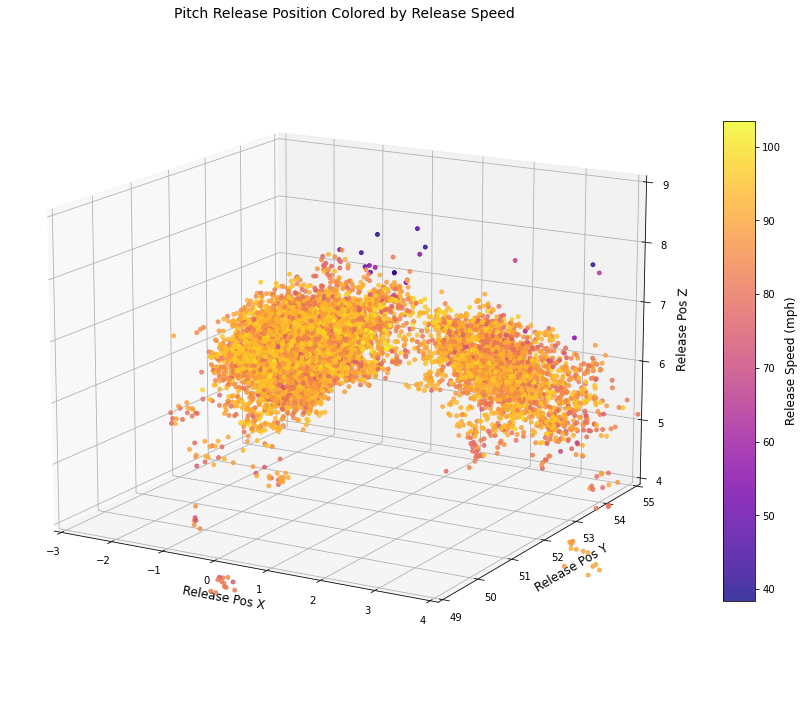

In [38]:
def improved_plot_release_speed_distribution(df, sample_size=10000):
    df_sampled = df.sample(n=sample_size, random_state=42)
    
    # 3D 
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        df_sampled['release_pos_x'],
        df_sampled['release_pos_y'],
        df_sampled['release_pos_z'],
        c=df_sampled['release_speed'],
        cmap='plasma',  
        alpha=0.8,
        s=15
    )
    

    ax.set_xlim(-3, 4)
    ax.set_ylim(49, 55)
    ax.set_zlim(4, 9)
    

    ax.set_xlabel('Release Pos X', fontsize=12)
    ax.set_ylabel('Release Pos Y', fontsize=12)
    ax.set_zlabel('Release Pos Z', fontsize=12)
    ax.set_title('Pitch Release Position Colored by Release Speed', fontsize=14)
    

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=15)
    cbar.set_label('Release Speed (mph)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    

    ax.view_init(elev=15, azim=-60)
    
    plt.tight_layout()
    plt.show()


improved_plot_release_speed_distribution(df)


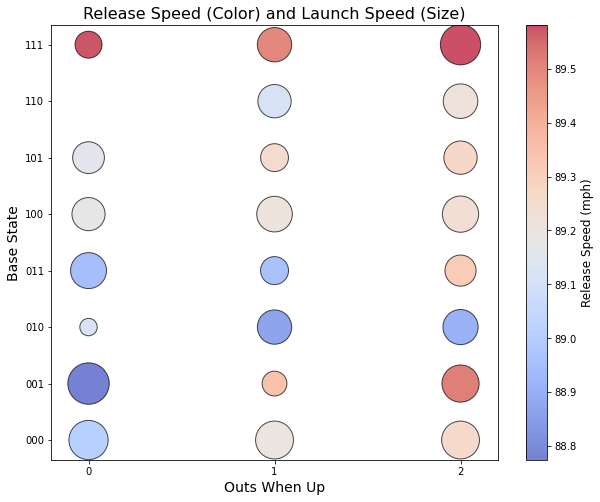

In [39]:
def plot_bubble_chart_v3(df):
    df['base_state'] = df['runner_on_1b'].astype(str) + df['runner_on_2b'].astype(str) + df['runner_on_3b'].astype(str)
    avg_data = df.groupby(['outs_when_up', 'base_state']).agg({'launch_speed': 'mean', 'release_speed': 'mean'}).reset_index()

    plt.figure(figsize=(10, 8))
    

    scatter = plt.scatter(
        avg_data['outs_when_up'],
        avg_data['base_state'],
        c=avg_data['release_speed'],  # 
        s=(avg_data['launch_speed'] - avg_data['launch_speed'].min()) * 500,  # 大小映射为 launch_speed
        cmap='coolwarm', 
        alpha=0.7,
        edgecolors='k'
    )
    

    cbar = plt.colorbar(scatter)
    cbar.set_label('Release Speed (mph)', fontsize=12)

    plt.xticks([0, 1, 2])  
    plt.gca().set_xlim(-0.2, 2.2)
    plt.title('Release Speed (Color) and Launch Speed (Size)', fontsize=16)
    plt.xlabel('Outs When Up', fontsize=14)
    plt.ylabel('Base State', fontsize=14)
    plt.show()

plot_bubble_chart_v3(df)


posx and posy should be finite values
posx and posy should be finite values


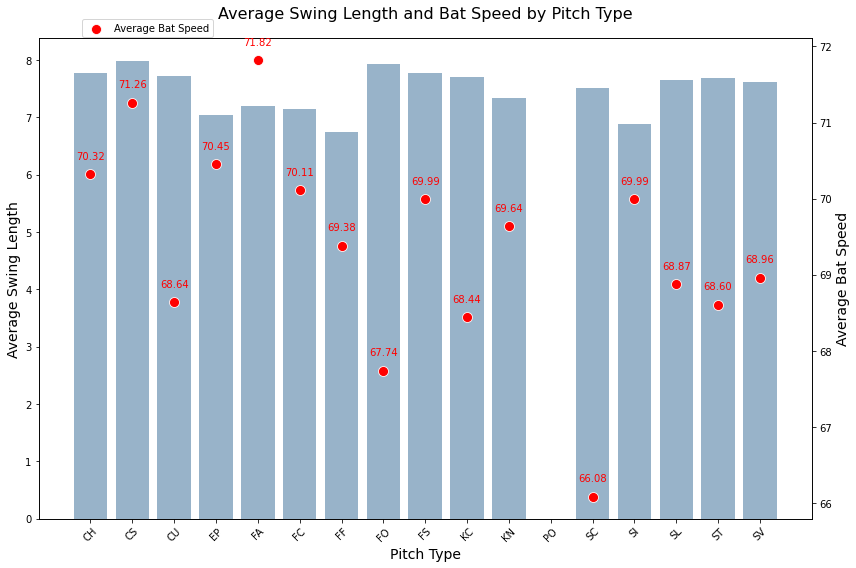

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def dual_axis_barplot_no_grid(df):

    df = df[df['pitch_name'] != 'PO']

    avg_data = df.groupby('pitch_type').agg({'swing_length': 'mean', 'bat_speed': 'mean'}).reset_index()


    fig, ax1 = plt.subplots(figsize=(12, 8))
    sns.barplot(x='pitch_type', y='swing_length', data=avg_data, ax=ax1, color='steelblue', alpha=0.6)
    ax1.set_ylabel('Average Swing Length', fontsize=14)
    ax1.set_xlabel('Pitch Type', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title('Average Swing Length and Bat Speed by Pitch Type', fontsize=16, pad=20)
    ax1.grid(False)


    ax2 = ax1.twinx()
    sns.scatterplot(x='pitch_type', y='bat_speed', data=avg_data, ax=ax2, color='red', s=100, marker='o')
    ax2.set_ylabel('Average Bat Speed', fontsize=14)
    ax2.grid(False)
    
    for i, row in avg_data.iterrows():
        ax2.text(i, row['bat_speed'] + 0.2, f'{row["bat_speed"]:.2f}', ha='center', fontsize=10, color='red')

    ax2.legend(['Average Bat Speed'], loc='upper left', bbox_to_anchor=(0.05, 1.05))


    plt.tight_layout()
    plt.show()


dual_axis_barplot_no_grid(df)


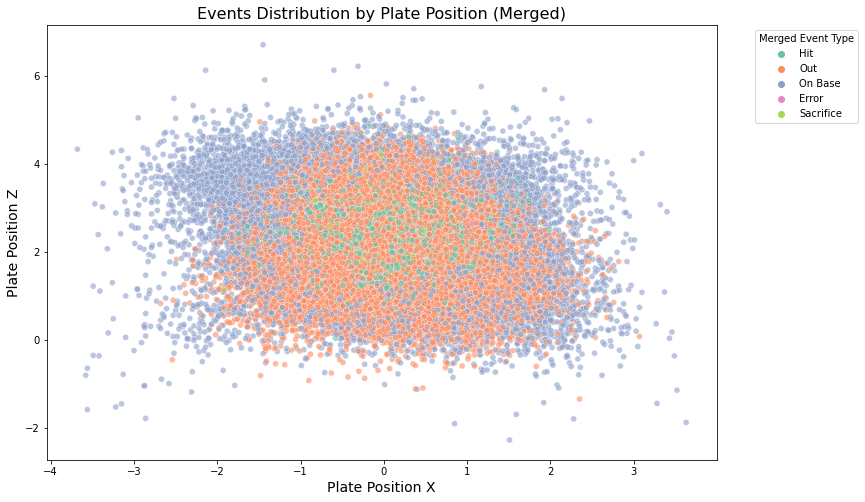

In [41]:
def merge_event_categories(df):
    df['events'] = df['events'].str.strip().str.lower()
    merged_events = []

    for event in df['events']:
        if event in ['single', 'double', 'triple', 'home_run']:
            merged_events.append('Hit')
        elif event in ['field_out', 'strikeout', 'double_play', 'grounded_into_double_play', 'triple_play', 'force_out']:
            merged_events.append('Out')
        elif event in ['walk', 'hit_by_pitch', 'catcher_interf']:
            merged_events.append('On Base')
        elif event in ['sac_fly', 'sac_bunt']:
            merged_events.append('Sacrifice')
        elif event == 'field_error':
            merged_events.append('Error')
        else:
            merged_events.append('Other')

    df['merged_events'] = merged_events
    return df


df = merge_event_categories(df)

# scatter plot
def scatter_events_distribution_merged(df):
    df = df[df['merged_events'] != 'Other']
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='plate_x', y='plate_z', hue='merged_events', data=df, palette='Set2', alpha=0.6)
    plt.title('Events Distribution by Plate Position (Merged)', fontsize=16)
    plt.xlabel('Plate Position X', fontsize=14)
    plt.ylabel('Plate Position Z', fontsize=14)
    plt.legend(title='Merged Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

scatter_events_distribution_merged(df)

<Figure size 1008x576 with 0 Axes>

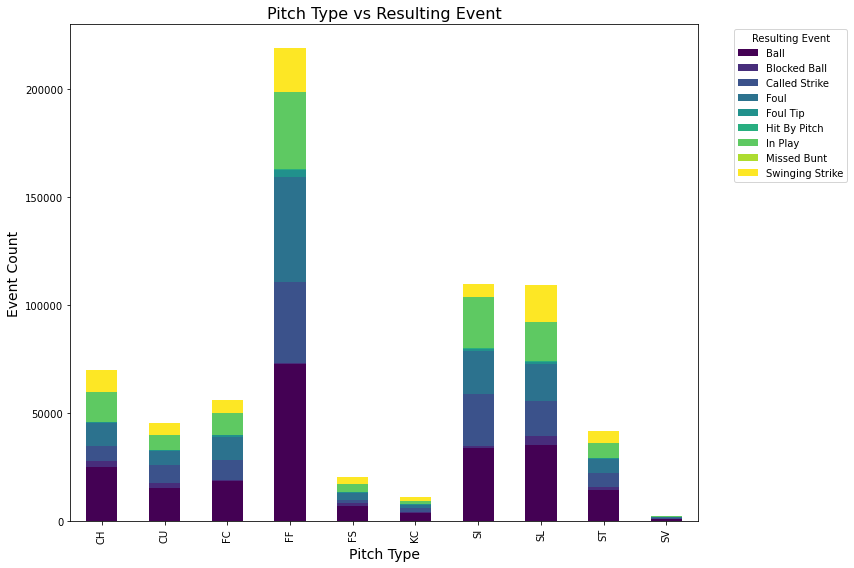

In [42]:
def merge_descriptions(df):
    description_mapping = {
        'foul': 'Foul',
        'foul_bunt': 'Foul',
        'called_strike': 'Called Strike',
        'foul_tip': 'Foul Tip',
        'swinging_strike': 'Swinging Strike',
        'swinging_strike_blocked': 'Swinging Strike',
        'hit_into_play': 'In Play',
        'blocked_ball': 'Blocked Ball',
        'missed_bunt': 'Missed Bunt',
        'bunt_foul_tip': 'Missed Bunt',
        'pitchout': 'Pitchout',
        'ball': 'Ball',
        'hit_by_pitch': 'Hit By Pitch'
    }
    
    df['merged_description'] = df['description'].map(description_mapping).fillna(df['description'])
    return df

def pitch_type_vs_events_stacked_bar(df, min_event_threshold=1000):
    """
    Plot a stacked bar chart, showing only pitch types with event counts above the threshold.
    """
    df = merge_descriptions(df)  # Merge event descriptions for simplicity
    
    # Count total events for each pitch_type
    pitch_type_counts = df['pitch_type'].value_counts()
    
    # Select pitch types with event counts greater than the threshold
    selected_pitch_types = pitch_type_counts[pitch_type_counts > min_event_threshold].index.tolist()
    filtered_df = df[df['pitch_type'].isin(selected_pitch_types)]
    
    plt.figure(figsize=(14, 8))
    event_counts = pd.crosstab(filtered_df['pitch_type'], filtered_df['merged_description'])
    event_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
    plt.title('Pitch Type vs Resulting Event', fontsize=16)
    plt.xlabel('Pitch Type', fontsize=14)
    plt.ylabel('Event Count', fontsize=14)
    plt.legend(title='Resulting Event', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


pitch_type_vs_events_stacked_bar(df, min_event_threshold=1000)
